In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AML Final Project

/content/drive/MyDrive/Colab Notebooks/AML Final Project


In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F

import torch
from torch import nn
from torch import optim

from undersampling import *
from dataset import *
from nets import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Image

In [ ]:
# dataset = TrainDataset('h5_train')
# save the dataset
# torch.save(dataset, 'dataset_normal.pth')

/content/drive/MyDrive/Colab Notebooks/AML Final Project/dataset.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  combined_image = combined_image.astype(np.float32)


In [ ]:
# load the dataset
dataset1 = torch.load('dataset_normal.pth')

train_samples = int(len(dataset1)*0.75)
print(len(dataset1))
test_samples = len(dataset1)-train_samples
train_set, test_set = torch.utils.data.random_split(dataset1, [train_samples, test_samples])
trainloader = DataLoader(train_set,shuffle=True)
testloader = DataLoader(test_set,shuffle=True)

160


In [ ]:
# # make a 10 image grid
# for i in range(10):
#     image = dataset1[i]
#     plt.figure(figsize=(10,5))
#     plt.subplot(1,2,1)
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')

#     k_space = np.fft.fft2(image)
#     k_space = np.fft.fftshift(k_space)
#     k_space = np.abs(k_space)
#     k_space = np.log(k_space)
#     plt.subplot(1,2,2)
#     plt.imshow(k_space, cmap='gray')
#     plt.axis('off')

# plt.show()


#Apply undersampling

In [ ]:
# construct undersampling mask
my_undersampling_factor = 10**2
my_lambda_poisson = 0.2

# undersample simpulation
hr_image = next(iter(trainloader))

# convert to 3 channel
hr_image_3 = hr_image.repeat(3, 1, 1)
hr_image_3 = hr_image_3.unsqueeze(0)
print(hr_image_3.shape)
print(hr_image_3)

torch.Size([1, 3, 320, 320])
tensor([[[[4.2267e-08, 4.2712e-08, 3.6203e-08,  ..., 4.6702e-08,
           4.6071e-08, 4.3510e-08],
          [3.6402e-08, 3.8173e-08, 3.8660e-08,  ..., 4.0362e-08,
           3.9416e-08, 3.5635e-08],
          [3.8321e-08, 3.5736e-08, 3.4085e-08,  ..., 3.7043e-08,
           3.7536e-08, 3.4410e-08],
          ...,
          [4.5354e-08, 5.3502e-08, 2.8487e-08,  ..., 3.4906e-08,
           4.0866e-08, 3.5827e-08],
          [4.4685e-08, 3.3619e-08, 3.8605e-08,  ..., 4.6014e-08,
           4.6086e-08, 4.0819e-08],
          [4.7459e-08, 3.4285e-08, 5.9571e-08,  ..., 3.4736e-08,
           4.8534e-08, 2.4162e-08]],

         [[4.2267e-08, 4.2712e-08, 3.6203e-08,  ..., 4.6702e-08,
           4.6071e-08, 4.3510e-08],
          [3.6402e-08, 3.8173e-08, 3.8660e-08,  ..., 4.0362e-08,
           3.9416e-08, 3.5635e-08],
          [3.8321e-08, 3.5736e-08, 3.4085e-08,  ..., 3.7043e-08,
           3.7536e-08, 3.4410e-08],
          ...,
          [4.5354e-08, 5.3502e

/content/drive/MyDrive/Colab Notebooks/AML Final Project/undersampling.py:60: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  mask = torch.cuda.FloatTensor(mask)


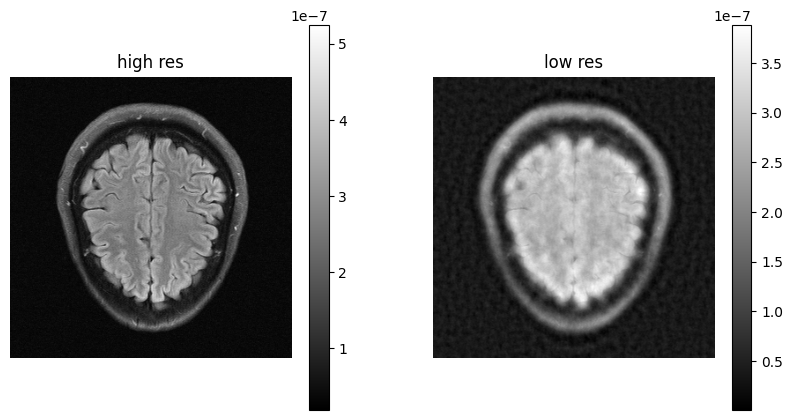

In [ ]:
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)
testLR_3 = A.AHA(hr_image_3.cuda())

grayscale_transform  = T.Grayscale(num_output_channels=1)
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('high res')

testLR_1 = grayscale_transform(testLR_3)
testLR_1 = testLR_1.squeeze(1)

# print(testLR_1)

plt.subplot(1,2,2)
plt.imshow(testLR_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('low res')

plt.show()



#CG Block

$$\mathbf x_{\rm LS} =  \arg \min_{\mathbf x} \|\mathbf A\mathbf x-\mathbf y\|^2 ---(2)$$

This problem is solved using conjugate gradient optimization, which gives $\mathbf x_{\rm LS} =  \left(\mathbf A^T \mathbf A + \lambda~ \mathbf I\right)^{-1}\left(\mathbf A^T\mathbf b\right)$, where $\lambda=0.01$.

In [ ]:
cg = cg_block(100,1e-4)
lhs = lambda x:A.AHA(x)+0.35*x # spatial
rhs = testLR_3
sigma = 0.1 * testLR_3.max()
noise = torch.randn(testLR_3.shape).cuda() * sigma.cuda()
x0 = testLR_3 + noise

print(rhs.shape)

out = cg(lhs,rhs,x0).detach().cpu()

print(out.max())
print(out.min())


torch.Size([1, 3, 320, 320])
tensor(2.5201e-07)
tensor(-9.1553e-08)


torch.Size([1, 3, 320, 320])
torch.Size([1, 3, 320, 320])


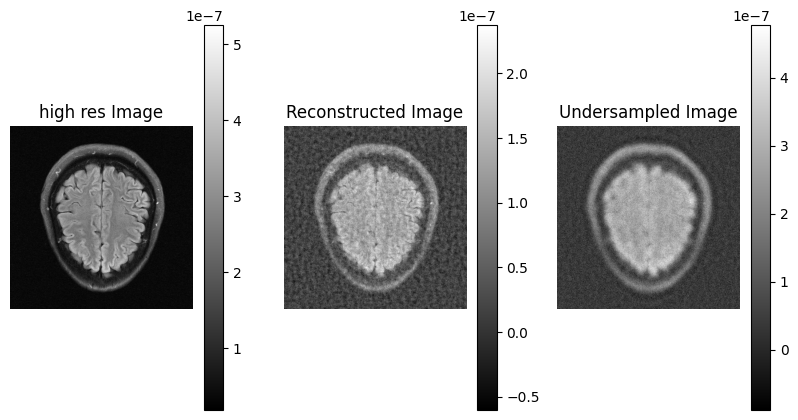

In [ ]:
print(out.shape)
print(testLR_3.shape)

out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)

# plot the images
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(hr_image.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('high res Image')

plt.subplot(1,3,2)
plt.imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Reconstructed Image')

x0_1 = grayscale_transform(x0)
x0_1 = x0_1.squeeze(1)

plt.subplot(1,3,3)
plt.imshow(x0_1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Undersampled Image')

plt.show()



In [ ]:
class modl(nn.Module):

    def __init__(self, A,net,lam,nCGiter=5,tol=1e-4,nUnrolls=1)-> None:
        super(modl, self).__init__();

        # Feature extraction layer.
        self.A = A
        self.net = net
        self.lam = torch.tensor(lam,dtype=torch.float64).requires_grad_(True)
        self.cg = cg = cg_block(nCGiter,tol)
        self.nUnrolls = nUnrolls

    def forward(self, Atb:torch.Tensor,x0:torch.Tensor ) -> torch.Tensor:

        x = x0.clone()

        lhs = lambda x: A.AHA(x)+self.lam*x

        for i in range(self.nUnrolls):
            z = Atb + self.lam*self.net(x)
            x = self.cg(lhs,z,x0=x)

        return x


0.00012139113387092948 lam= 0.15000760887800638


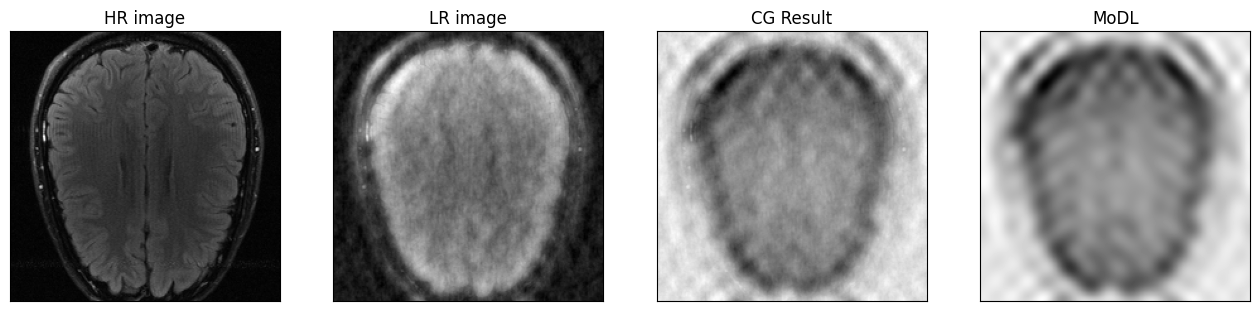

0.00012122893240302801 lam= 0.1500355548510631


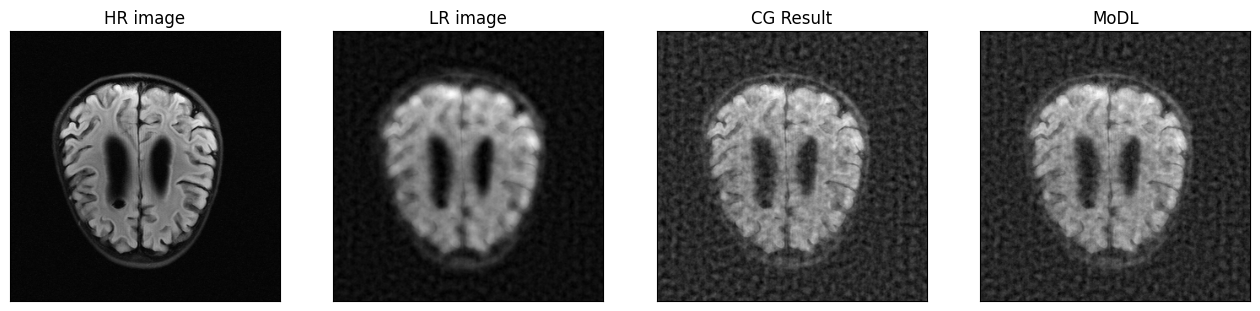

0.00012128428788855672 lam= 0.15006248562513955


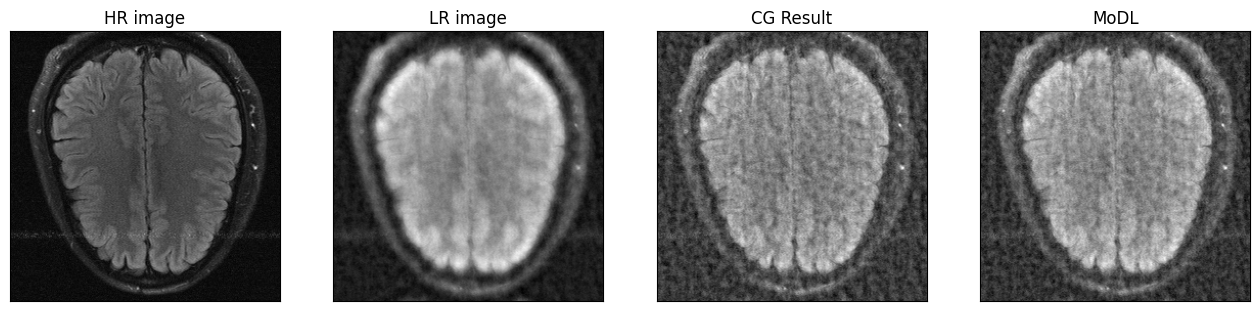

0.00012145396322011947 lam= 0.15008957960027533


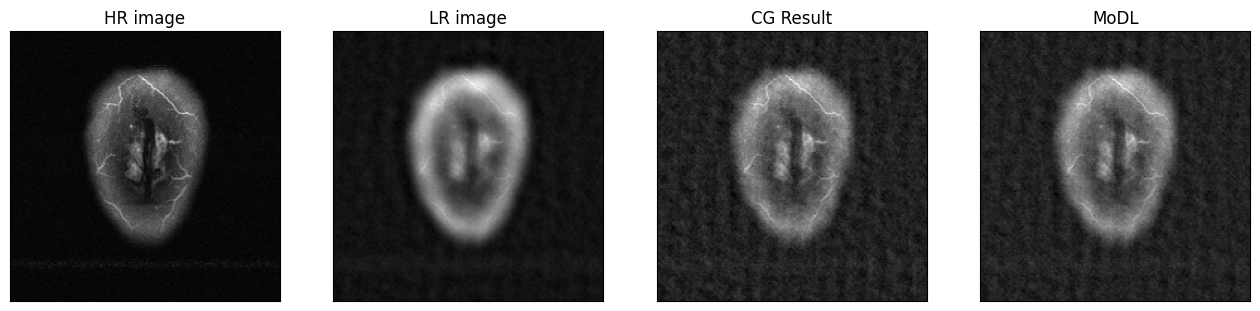

0.00012138690799474716 lam= 0.1501165454405827


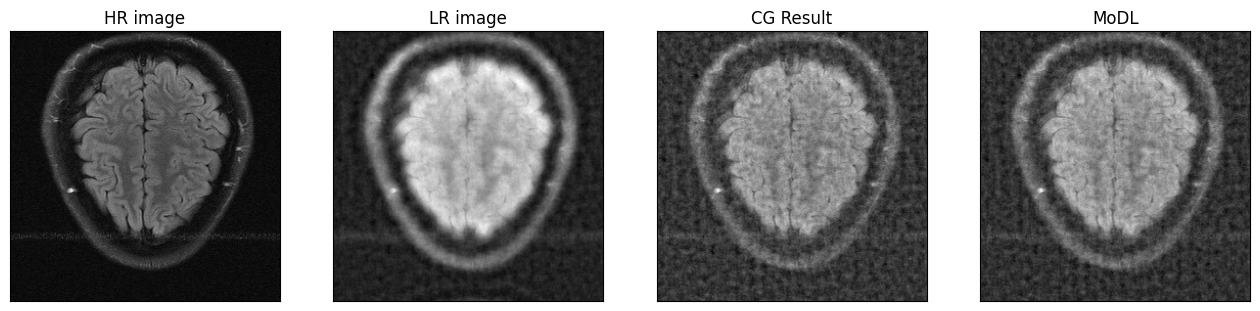

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_undersampling_factor = 10**2
my_lambda_poisson = 0.2
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)
net = SRCNN(32,upSamplingFactor=1).to(device)
maxUnrolls = 5
model = modl(A,net,0.15,nUnrolls=maxUnrolls)

lossfn = torch.nn.L1Loss(reduction='mean')

optimizer = optim.SGD([
                {'params': model.net.parameters(),'lr': 1e-3},
                {'params':model.lam,'lr': 1e-3}
            ], lr=1e-3, momentum=0.6)


for epoch in range(15):
    epochloss = 0

    for hr_image in trainloader:

        # 1-3 channel
        hr_image_3 = hr_image.repeat(3, 1, 1)
        hr_image_3 = hr_image_3.unsqueeze(0)
        # print(hr_image_3.shape)

        testHR = A.AHA(hr_image_3.cuda())
        sigma = 0.05 * testHR.max()
        noise = torch.randn(testHR.shape).cuda() * sigma.cuda()
        cg_start = testHR + noise
        x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()


        testHR = testHR.to(torch.float32)
        x0 = x0.to(torch.float32)
        out = model(testHR.to(device),x0.to(device))

        cost =lossfn(out,hr_image_3.to(device))
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        epochloss += cost
    if np.mod(epoch,3)==0:
        print(epochloss.item()/dataset1.__len__(),'lam=',model.lam.item())

        fig, ax = plt.subplots(1,4,figsize=(16,4))
        # gray scale
        hr_image_1 = grayscale_transform(hr_image_3)
        hr_image_1 = hr_image_1.squeeze(1)
        s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[0].set_title('HR image')
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)

        testHR_1 = grayscale_transform(testHR)
        testHR_1 = testHR_1.squeeze(1)
        s=ax[1].imshow(testHR_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[1].set_title('LR image')
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)


        cgresult = cg(lhs,testHR,testHR).detach().cpu()
        # gray scale
        cgresult_1 = grayscale_transform(cgresult)
        cgresult_1 = cgresult_1.squeeze(1)
        s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[2].set_title('CG Result')
        s=ax[2].get_xaxis().set_visible(False)
        s=ax[2].get_yaxis().set_visible(False)

        out_1 = grayscale_transform(out)
        out_1 = out_1.squeeze(1)
        s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
        s=ax[3].set_title('MoDL')
        ax[3].get_xaxis().set_visible(False)
        ax[3].get_yaxis().set_visible(False)
        #if(nUnrolls<maxUnrolls):
        #    nUnrolls = nUnrolls+1

        plt.show()



In [ ]:
# save the model
# torch.save(model.state_dict(), '04_08_300_mask_10_05.pth')
torch.save(model.state_dict(), '04_08_fine_tune_2.pth')


#Testing

##Show results from noisy

In [ ]:
# calculate the PSNR
def psnr(og, pre):
    og = og.cpu()
    pre = pre.cpu()
    psnr = 10*torch.log10(og.max()/torch.mean((pre-og)**2))
    return psnr

Results from noisy image


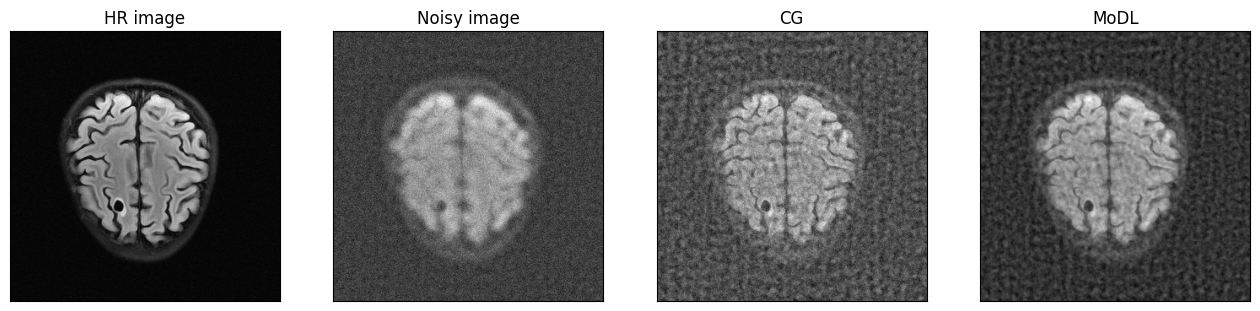

PSNR with noisy image: tensor(81.4113)
PSNR with cg: tensor(77.6045)
PSNR with modl: tensor(85.0416, grad_fn=<MulBackward0>)
Results from undersampling image


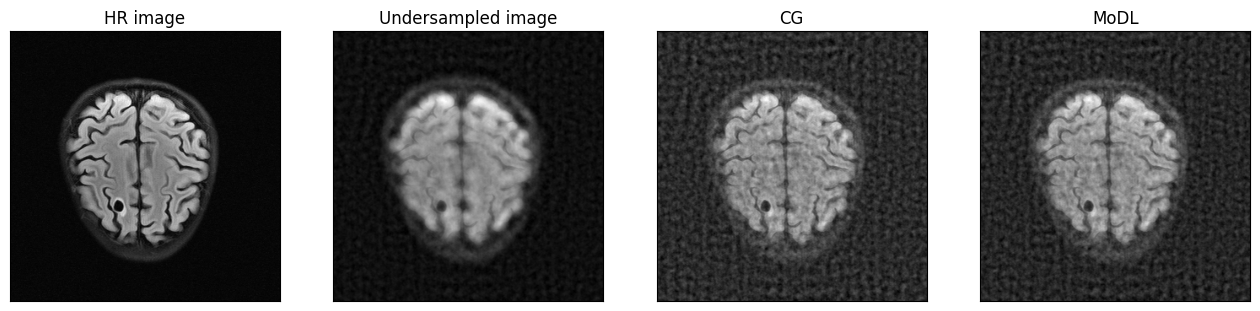

PSNR with undersampled image: tensor(87.1537)
PSNR with cg: tensor(79.9755)
PSNR with modl: tensor(85.9350, grad_fn=<MulBackward0>)


In [ ]:
hr_image = next(iter(testloader))

my_undersampling_factor = 10**2
my_lambda_poisson = 0.2
A = underSamplingOperator(my_undersampling_factor, my_lambda_poisson)

# 1-3 channel
hr_image_3 = hr_image.repeat(3, 1, 1)
hr_image_3 = hr_image_3.unsqueeze(0)

testHR = A.AHA(hr_image_3.cuda())
sigma = 0.1 * testHR.max()
noise = torch.randn(testHR.shape).cuda() * sigma.cuda()
cg_start = testHR + noise
x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()

testHR = testHR.to(torch.float32)
x0 = x0.to(torch.float32)
out = model(testHR.to(device),x0.to(device))


# plots from noisy
print('Results from noisy image')
fig, ax = plt.subplots(1,4,figsize=(16,4))

# display original
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)
s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# display noisy
cgresult_1 = grayscale_transform(cg_start)
cg_start_1 = cgresult_1.squeeze(1)
s=ax[1].imshow(cg_start_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[1].set_title('Noisy image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# cg from noise
cgresult_1 = grayscale_transform(x0)
cgresult_1 = cgresult_1.squeeze(1)
s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[2].set_title('CG')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

# modl output
out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)
s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()

# calculate the psnr
psnr_noisy = psnr(hr_image_3,cg_start)
psnr_cg = psnr(hr_image_3,x0)
psnr_modl = psnr(hr_image_3,out)
print('PSNR with noisy image:',psnr_noisy)
print('PSNR with cg:',psnr_cg)
print('PSNR with modl:',psnr_modl)



#--------------------------------------------------------------------------

cg_start = testHR
x0 = cg(lhs,testHR.cuda(),cg_start.cuda()).detach().cpu()

testHR = testHR.to(torch.float32)
x0 = x0.to(torch.float32)
out = model(testHR.to(device),x0.to(device))


# plots from undersampling
print('Results from undersampling image')
fig, ax = plt.subplots(1,4,figsize=(16,4))

# display original
hr_image_1 = grayscale_transform(hr_image_3)
hr_image_1 = hr_image_1.squeeze(1)
s=ax[0].imshow(hr_image_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[0].set_title('HR image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# display undersampling
cgresult_1 = grayscale_transform(cg_start)
cg_start_1 = cgresult_1.squeeze(1)
s=ax[1].imshow(cg_start_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[1].set_title('Undersampled image')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# cg from undersampling
cgresult_1 = grayscale_transform(x0)
cgresult_1 = cgresult_1.squeeze(1)
s=ax[2].imshow(cgresult_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[2].set_title('CG')
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

# modl output
out_1 = grayscale_transform(out)
out_1 = out_1.squeeze(1)
s=ax[3].imshow(out_1.cpu().detach().numpy().squeeze(), cmap='gray')
s=ax[3].set_title('MoDL')
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)

plt.show()

# calculate the psnr
psnr_under = psnr(hr_image_3,cg_start)
psnr_cg = psnr(hr_image_3,x0)
psnr_modl = psnr(hr_image_3,out)
print('PSNR with undersampled image:',psnr_under)
print('PSNR with cg:',psnr_cg)
print('PSNR with modl:',psnr_modl)